In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import rpy2.robjects as robjects
import statsmodels.api as sm
from statsmodels.formula.api import ols
from astsadata import *
import warnings

/Users/juancamilopico/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


## 1. Cargar datos

In [23]:
data_full = pd.read_csv("time_series_60min_singleindex.csv")
data = data_full[['utc_timestamp','AT_load_actual_entsoe_transparency']][40000:].copy()
data.head()

,utc_timestamp,AT_load_actual_entsoe_transparency
40000,2019-07-25T15:00:00Z,8172.0
40001,2019-07-25T16:00:00Z,8107.0
40002,2019-07-25T17:00:00Z,7781.0
40003,2019-07-25T18:00:00Z,7436.0
40004,2019-07-25T19:00:00Z,7219.0


In [24]:
data.shape

(10401, 2)

1.1. Formato correcto

In [25]:
data[['utc_timestamp']] = data[['utc_timestamp']].apply(pd.to_datetime)
data['local_timestamp'] = data['utc_timestamp'].dt.tz_convert('Europe/Vienna')
data.head()

,utc_timestamp,AT_load_actual_entsoe_transparency,local_timestamp
40000,2019-07-25 15:00:00+00:00,8172.0,2019-07-25 17:00:00+02:00
40001,2019-07-25 16:00:00+00:00,8107.0,2019-07-25 18:00:00+02:00
40002,2019-07-25 17:00:00+00:00,7781.0,2019-07-25 19:00:00+02:00
40003,2019-07-25 18:00:00+00:00,7436.0,2019-07-25 20:00:00+02:00
40004,2019-07-25 19:00:00+00:00,7219.0,2019-07-25 21:00:00+02:00


1.2. Quitar datos nulos

In [26]:
data = data.dropna()
data.shape

(10401, 3)

1.3. Convertir la fecha en el index de la serie

In [27]:
data.index = data["local_timestamp"]
data.drop(columns=['utc_timestamp', 'local_timestamp'], inplace=True)
data.head()

,AT_load_actual_entsoe_transparency
local_timestamp,
2019-07-25 17:00:00+02:00,8172.0
2019-07-25 18:00:00+02:00,8107.0
2019-07-25 19:00:00+02:00,7781.0
2019-07-25 20:00:00+02:00,7436.0
2019-07-25 21:00:00+02:00,7219.0


## 2. Análisis de datos

### Funciones de soporte para graficar funciones de autocorrelación

In [7]:
def acf1(x, nlags=None, acf_type="correlation", pacf=False, ax=None, **kwargs):
    lags = np.arange(1, nlags + 1)

    if pacf:
        if acf_type == "correlation":
            values = sm.tsa.pacf(x, nlags=nlags)[1:]
            ylabel = "PACF"
    else:
        if acf_type == "correlation":
            values = sm.tsa.acf(x, nlags=nlags, fft=False)[1:]
            ylabel = "ACF"
        elif acf_type == "covariance":
            values = sm.tsa.acovf(x, nlag=nlags)[1:]
            ylabel = "ACoV"

    if ax is None:
        ax = plt.gca()
 
    ax.bar(lags, values, **kwargs)
    ax.axhline(0, color="black", linewidth=1)
    if acf_type == "correlation":
        conf_level = 1.96 / np.sqrt(x.shape[0])
        ax.axhline(conf_level, color="red", linestyle="--", linewidth=1)
        ax.axhline(-conf_level, color="red", linestyle="--", linewidth=1)
    ax.set_xlabel("LAG")
    ax.set_ylabel(ylabel)

    return ax

<AxesSubplot:xlabel='local_timestamp'>

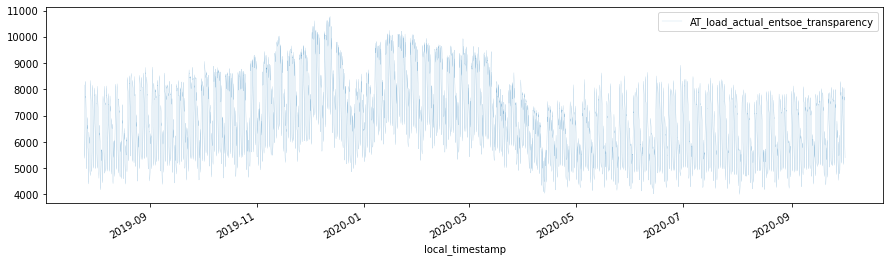

In [8]:
# Graficar serie
data.plot(figsize=(15, 4), linewidth=0.1)

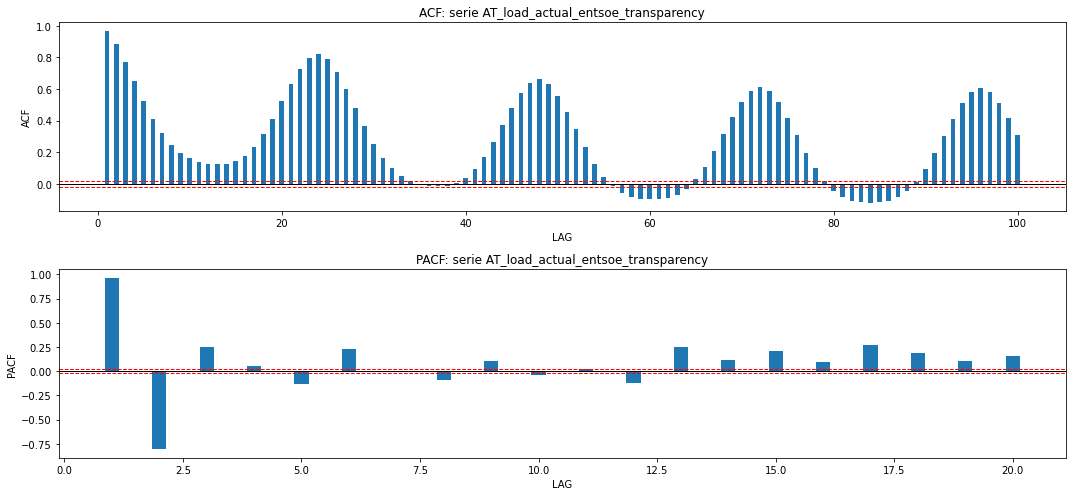

In [9]:
# ACF y PACF de la serie AT_load_actual_entsoe_transparency
fig, axes = plt.subplots(nrows=2, figsize=(15, 7))

acf1(data, nlags=100, ax=axes[0], width=.5)
axes[0].set_title("ACF: serie AT_load_actual_entsoe_transparency")

acf1(data, nlags=20, pacf=True, ax=axes[1], width=.3)
axes[1].set_title("PACF: serie AT_load_actual_entsoe_transparency")

fig.tight_layout()
plt.show()

## 3. Modelo 

In [28]:
# , trend="c"
model = sm.tsa.SARIMAX(data, order = (2,1,2),seasonal_order=(2, 1, 2, 24)).fit() # SARIMA(1,0,0)
model.summary()

/Users/juancamilopico/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/juancamilopico/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/juancamilopico/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:     AT_load_actual_entsoe_transparency   No. Observations:                10401
Model:                 SARIMAX(2, 1, 2)x(2, 1, 2, 24)   Log Likelihood              -60973.443
Date:                                Wed, 07 Dec 2022   AIC                         121964.887
Time:                                        17:54:36   BIC                         122030.112
Sample:                                             0   HQIC                        121986.925
                                              - 10401                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2481      0.047      5.274      0.000       0.156       0.340
ar.L2         -0.0317      0.029     -1.075      0.282      -0.090       0.026
ma.L1          0.5446      0.048     11.402      0.000       0.451       0.638
ma.L2          0.3111      0.016     19.583      0.000       0.280       0.342
ar.S.L24       0.9719      0.011     91.037      0.000       0.951       0.993
ar.S.L48      -0.5102      0.007    -69.682      0.000      -0.525      -0.496
ma.S.L24      -1.5344      0.012   -124.072      0.000      -1.559      -1.510
ma.S.L48       0.6931      0.011     63.215      0.000       0.672       0.715
sigma2      7415.0737     66.593    111.350      0.000    7284.554    7545.593
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5268.85
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

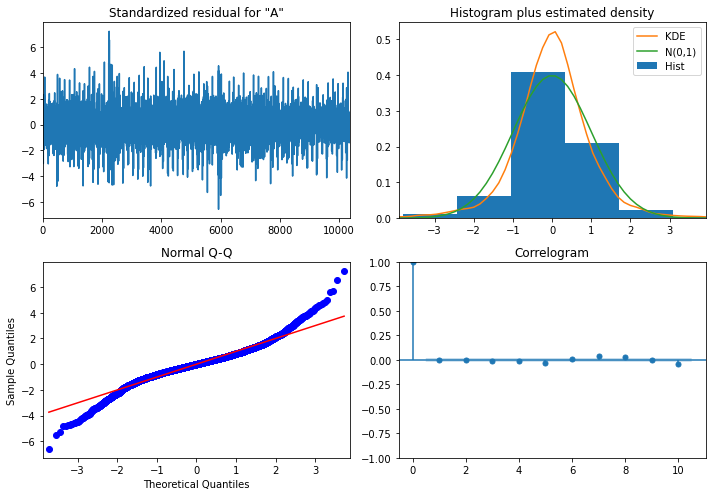

In [29]:
fig = model.plot_diagnostics(figsize=(10, 7))
fig.tight_layout()
plt.show()

In [30]:
model.save("SARIMA21221224.pkl")

In [ ]:
fig = plt.subplots(figsize=(15, 4))
serie_pr = model.get_prediction(start=40000+len(serie), end=40000+len(serie) + 24)
U = serie_pr.predicted_mean + serie_pr.se_mean
L = serie_pr.predicted_mean - serie_pr.se_mean

serie[-48:].plot(xlabel="Time", legend=False)
serie_pr.predicted_mean.plot(marker="o")
plt.plot(U, color="red", linestyle="--")
plt.plot(L, color="red", linestyle="--")
plt.show()

In [31]:
from pandas.tseries.offsets import DateOffset
pred_date=[data.index[-1] + DateOffset(hours=x)for x in range(0,25)]

In [32]:
data_pred = data.copy()
data_pred["forecast"] = np.nan
pred_date=pd.DataFrame(index=pred_date[1:],columns=data.columns)

In [33]:
data_pred=pd.concat([data_pred,pred_date])

In [34]:
forecast = model.predict(start = len(data), end = len(data)+23)
forecast.index = pred_date.index

/Users/juancamilopico/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [35]:
data_pred['forecast'] = forecast

In [36]:
import plotly.express as px

px.line(data_pred.loc['2020-09-28':], markers=True)

Para cargar el modelo:

In [ ]:
model2 = sm.tsa.statespace.sarimax.SARIMAXResults.load("SARIMA10010024.pkl")

In [ ]:
import plotly.express as px

datos = data[data['local_timestamp']>=r]
px.line(datos, x='local_timestamp', y="AT_load_actual_entsoe_transparency", markers=True)